<a href="https://colab.research.google.com/github/tulasipraneeth/SNN-Fruit-Detection-and-Counting/blob/main/mini.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install opencv-python-headless
!pip install snntorch
!pip install torch torchvision
!pip install matplotlib
import cv2
import numpy as np
import torch
import snntorch as snn
from snntorch import surrogate
from snntorch import utils
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from google.colab import files
%matplotlib inline

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.6/125.6 kB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 68.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 36.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 59.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 75.1 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstall

In [3]:
uploaded = files.upload()
video_filename = list(uploaded.keys())[0]
print(f"Uploaded video: {video_filename}")

Saving v-2.mp4 to v-2.mp4
Uploaded video: v-2.mp4


In [4]:
def preprocess_frame(frame, target_size=(128, 128)):
    frame_resized = cv2.resize(frame, target_size)
    frame_gray = cv2.cvtColor(frame_resized, cv2.COLOR_BGR2GRAY)
    frame_normalized = frame_gray / 255.0
    return frame_normalized

cap = cv2.VideoCapture(video_filename)
if not cap.isOpened():
    print("Error: Could not open video.")
    exit()

preprocessed_frames = []
while True:
    ret, frame = cap.read()
    if not ret:
        break
    preprocessed_frame = preprocess_frame(frame)
    preprocessed_frames.append(preprocessed_frame)

cap.release()
print(f"Total frames extracted: {len(preprocessed_frames)}")

frames_tensor = torch.tensor(preprocessed_frames).float().unsqueeze(1)
print(f"Frames tensor shape: {frames_tensor.shape}")

Total frames extracted: 945
Frames tensor shape: torch.Size([945, 1, 128, 128])


/tmp/ipython-input-4-1722602320.py:23: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  frames_tensor = torch.tensor(preprocessed_frames).float().unsqueeze(1)


In [5]:
def detect_fruits_in_frame(frame, lower_red1, upper_red1, lower_red2, upper_red2):
    hsv_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
    mask1 = cv2.inRange(hsv_frame, lower_red1, upper_red1)
    mask2 = cv2.inRange(hsv_frame, lower_red2, upper_red2)
    mask = cv2.bitwise_or(mask1, mask2)
    kernel = np.ones((3,3), np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel, iterations=1)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel, iterations=1)
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    boxes = []
    for contour in contours:
        area = cv2.contourArea(contour)
        if area > 100:
            x, y, w, h = cv2.boundingRect(contour)
            boxes.append((x, y, w, h))
    return boxes
lower_red1 = np.array([0, 100, 50])
upper_red1 = np.array([15, 255, 255])
lower_red2 = np.array([165, 100, 50])
upper_red2 = np.array([180, 255, 255])

cap = cv2.VideoCapture(video_filename)
frame_count = 0
fruit_counts_per_frame = []
detected_boxes_per_frame = []

while True:
    ret, frame = cap.read()
    if not ret:
        break
    boxes = detect_fruits_in_frame(frame, lower_red1, upper_red1, lower_red2, upper_red2)
    fruit_counts_per_frame.append(len(boxes))
    detected_boxes_per_frame.append(boxes)

    # Draw bounding boxes
    frame_with_boxes = frame.copy()
    for (x, y, w, h) in boxes:
        cv2.rectangle(frame_with_boxes, (x, y), (x + w, y + h), (0, 255, 0), 2)
        cv2.putText(frame_with_boxes, "Apple", (x, y - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

    cv2.imwrite(f"frame_{frame_count}_detected.jpg", frame_with_boxes)
    frame_count += 1

cap.release()
print(f"Fruit counts per frame: {fruit_counts_per_frame}")
print(f"Total fruits detected: {sum(fruit_counts_per_frame)}")

Fruit counts per frame: [37, 39, 38, 38, 38, 38, 37, 38, 37, 37, 37, 39, 37, 38, 38, 38, 39, 39, 39, 38, 38, 40, 39, 38, 40, 40, 39, 39, 39, 39, 40, 40, 40, 39, 38, 39, 39, 39, 39, 40, 41, 38, 41, 40, 41, 39, 38, 39, 40, 39, 41, 39, 39, 39, 39, 40, 41, 40, 40, 39, 38, 39, 38, 39, 39, 39, 40, 41, 38, 37, 38, 40, 37, 38, 40, 39, 38, 38, 38, 40, 38, 39, 38, 38, 37, 39, 39, 38, 37, 37, 39, 38, 37, 36, 37, 36, 36, 34, 37, 37, 37, 36, 38, 37, 37, 37, 38, 36, 36, 36, 37, 37, 38, 37, 37, 39, 39, 37, 38, 39, 37, 38, 38, 37, 38, 38, 37, 39, 37, 38, 40, 39, 39, 39, 37, 39, 39, 39, 39, 37, 37, 37, 37, 38, 38, 38, 39, 37, 40, 40, 38, 38, 37, 37, 39, 39, 37, 39, 38, 38, 39, 37, 39, 38, 37, 39, 37, 39, 36, 39, 40, 39, 37, 39, 36, 38, 39, 39, 38, 37, 38, 37, 37, 40, 38, 40, 37, 39, 39, 38, 39, 40, 38, 41, 38, 40, 38, 38, 39, 37, 38, 38, 39, 38, 38, 39, 39, 39, 40, 37, 38, 39, 38, 39, 39, 38, 40, 39, 39, 40, 39, 40, 41, 39, 39, 40, 41, 40, 40, 39, 42, 41, 41, 41, 41, 42, 41, 41, 42, 41, 41, 40, 41, 42,

In [6]:
cap = cv2.VideoCapture(video_filename)
frame_count = 0
fruit_counts_per_frame = []
detected_boxes_per_frame = []

while True:
    ret, frame = cap.read()
    if not ret:
        break
    boxes = detect_fruits_in_frame(frame, lower_red1, upper_red1, lower_red2, upper_red2)
    fruit_counts_per_frame.append(len(boxes))
    detected_boxes_per_frame.append(boxes)  # List of (x, y, w, h) per frame
    frame_count += 1

cap.release()


In [7]:
num_inputs = 128 * 128
num_hidden = 512
num_outputs = 1
num_steps = 25
beta = 0.95

class FruitDetectionSNN(torch.nn.Module):
    def __init__(self):
        super(FruitDetectionSNN, self).__init__()
        self.fc1 = torch.nn.Linear(num_inputs, num_hidden)
        self.lif1 = snn.Leaky(beta=beta, spike_grad=surrogate.fast_sigmoid())
        self.fc2 = torch.nn.Linear(num_hidden, num_outputs)
        self.lif2 = snn.Leaky(beta=beta, spike_grad=surrogate.fast_sigmoid())

    def forward(self, x):
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()
        spk2_rec = []
        for step in range(num_steps):
            cur1 = self.fc1(x)
            spk1, mem1 = self.lif1(cur1, mem1)
            cur2 = self.fc2(spk1)
            spk2, mem2 = self.lif2(cur2, mem2)
            spk2_rec.append(spk2)
        return torch.stack(spk2_rec)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
snn_model = FruitDetectionSNN().to(device)
print("SNN model defined.")

SNN model defined.


In [8]:
def frames_to_spikes(frames_tensor, num_steps):
    torch.manual_seed(42)
    spike_trains = []
    for t in range(num_steps):
        spikes = torch.rand(frames_tensor.shape) < frames_tensor
        spike_trains.append(spikes.float())
    return torch.stack(spike_trains)

spike_trains = frames_to_spikes(frames_tensor, num_steps)
print(f"Spike trains shape: {spike_trains.shape}")

Spike trains shape: torch.Size([25, 945, 1, 128, 128])


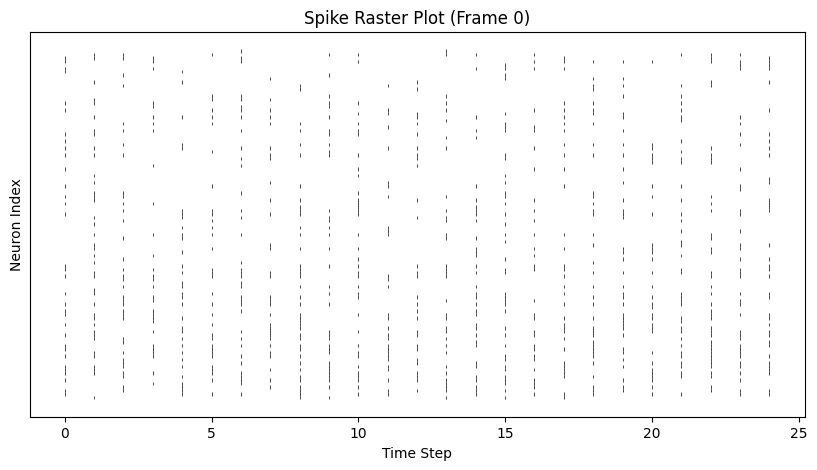

In [9]:
def plot_spike_raster(spike_data, frame_idx=0, neuron_sample=100):

    spikes = spike_data[:, frame_idx, 0].flatten(start_dim=1)


    if spikes.shape[1] > neuron_sample:
        spikes = spikes[:, ::spikes.shape[1]//neuron_sample]


    plt.figure(figsize=(10, 5))
    for neuron in range(spikes.shape[1]):
        spike_times = np.where(spikes[:, neuron].cpu().numpy() > 0)[0]
        plt.vlines(spike_times, neuron-0.5, neuron+0.5, color='black', linewidth=0.5)

    plt.xlabel('Time Step')
    plt.ylabel('Neuron Index')
    plt.title(f'Spike Raster Plot (Frame {frame_idx})')
    plt.yticks([])
    plt.show()

plot_spike_raster(spike_trains, frame_idx=0)

In [ ]:
spikes = torch.rand(frames_tensor.shape) < frames_tensor

In [10]:
snn_outputs = []
for frame_idx in range(spike_trains.shape[1]):
    frame_spikes = spike_trains[:, frame_idx, 0, :, :].to(device)
    frame_spikes_flat = frame_spikes.view(num_steps, -1)
    spk = snn_model(frame_spikes_flat)
    confidence = spk.sum().item() / num_steps
    snn_outputs.append(confidence)

print(f"SNN confidence scores per frame: {snn_outputs}")

SNN confidence scores per frame: [0.48, 0.2, 0.24, 0.2, 0.2, 0.0, 0.04, 0.04, 0.16, 0.08, 0.24, 0.04, 0.04, 0.08, 0.16, 0.16, 0.24, 0.16, 0.08, 0.0, 0.04, 0.2, 0.08, 0.04, 0.04, 0.08, 0.0, 0.08, 0.04, 0.12, 0.08, 0.2, 0.32, 0.0, 0.16, 0.2, 0.24, 0.08, 0.12, 0.08, 0.24, 0.28, 0.2, 0.12, 0.24, 0.36, 0.48, 0.08, 0.2, 0.28, 0.28, 0.08, 0.04, 0.16, 0.04, 0.2, 0.0, 0.2, 0.0, 0.0, 0.04, 0.04, 0.2, 0.04, 0.08, 0.08, 0.16, 0.04, 0.08, 0.12, 0.08, 0.04, 0.0, 0.04, 0.0, 0.0, 0.04, 0.12, 0.16, 0.12, 0.04, 0.08, 0.0, 0.2, 0.0, 0.0, 0.2, 0.08, 0.12, 0.0, 0.0, 0.0, 0.12, 0.04, 0.12, 0.08, 0.08, 0.2, 0.2, 0.04, 0.08, 0.08, 0.04, 0.0, 0.16, 0.12, 0.04, 0.12, 0.04, 0.0, 0.0, 0.12, 0.0, 0.08, 0.24, 0.0, 0.12, 0.12, 0.16, 0.08, 0.04, 0.04, 0.04, 0.16, 0.0, 0.08, 0.2, 0.0, 0.04, 0.0, 0.32, 0.04, 0.0, 0.12, 0.0, 0.04, 0.32, 0.16, 0.12, 0.12, 0.12, 0.2, 0.12, 0.04, 0.12, 0.08, 0.0, 0.28, 0.08, 0.28, 0.0, 0.0, 0.04, 0.12, 0.04, 0.04, 0.0, 0.08, 0.16, 0.2, 0.08, 0.28, 0.16, 0.16, 0.16, 0.0, 0.04, 0.44, 0.08, 0

In [11]:
from scipy.spatial import distance

def is_duplicate(new_box, tracked_boxes, threshold=50):
    """Check if a new box is close to any tracked box."""
    new_center = (new_box[0] + new_box[2] / 2, new_box[1] + new_box[3] / 2)  # (x + w/2, y + h/2)
    for tracked_box in tracked_boxes:
        tracked_center = (tracked_box[0] + tracked_box[2] / 2, tracked_box[1] + tracked_box[3] / 2)
        dist = distance.euclidean(new_center, tracked_center)
        if dist < threshold:
            return True
    return False
filtered_fruit_counts = []
confidence_threshold = 0.1
tracked_boxes = []

if len(fruit_counts_per_frame) != len(snn_outputs) or len(detected_boxes_per_frame) != len(snn_outputs):
    raise ValueError("Mismatch in lengths of fruit_counts_per_frame, detected_boxes_per_frame, and snn_outputs.")

for frame_idx, (count, confidence, boxes) in enumerate(zip(fruit_counts_per_frame, snn_outputs, detected_boxes_per_frame)):
    frame_count = 0
    if confidence > confidence_threshold:
        frame_count = len(boxes)
        for box in boxes:
            if not is_duplicate(box, tracked_boxes):
                tracked_boxes.append(box)
    filtered_fruit_counts.append(frame_count)

total_apples_no_duplicates = len(tracked_boxes)

print(f"Filtered fruit counts per frame (all apples): {filtered_fruit_counts}")
print(f"Total apples after removing duplicates across frames: {int(total_apples_no_duplicates)}")

Filtered fruit counts per frame (all apples): [37, 39, 38, 38, 38, 0, 0, 0, 37, 0, 37, 0, 0, 0, 38, 38, 39, 39, 0, 0, 0, 40, 0, 0, 0, 0, 0, 0, 0, 39, 0, 40, 40, 0, 38, 39, 39, 0, 39, 0, 41, 38, 41, 40, 41, 39, 38, 0, 40, 39, 41, 0, 0, 39, 0, 40, 0, 40, 0, 0, 0, 0, 38, 0, 0, 0, 40, 0, 0, 37, 0, 0, 0, 0, 0, 0, 0, 38, 38, 40, 0, 0, 0, 38, 0, 0, 39, 0, 37, 0, 0, 0, 37, 0, 37, 0, 0, 34, 37, 0, 0, 0, 0, 0, 37, 37, 0, 36, 0, 0, 0, 37, 0, 0, 37, 0, 39, 37, 38, 0, 0, 0, 0, 37, 0, 0, 37, 0, 0, 0, 40, 0, 0, 39, 0, 0, 39, 39, 39, 37, 37, 37, 37, 0, 38, 0, 0, 37, 0, 40, 0, 0, 0, 37, 0, 0, 0, 0, 38, 38, 0, 37, 39, 38, 37, 0, 0, 39, 0, 0, 40, 0, 0, 39, 36, 0, 39, 39, 38, 37, 38, 37, 37, 40, 38, 40, 37, 39, 39, 38, 39, 40, 38, 41, 38, 40, 38, 38, 39, 37, 38, 38, 39, 38, 38, 0, 39, 39, 0, 37, 38, 39, 38, 39, 39, 0, 0, 0, 0, 40, 0, 40, 41, 0, 39, 0, 0, 0, 40, 0, 42, 41, 41, 41, 0, 0, 41, 41, 42, 41, 0, 40, 0, 0, 0, 0, 42, 42, 42, 42, 40, 42, 42, 0, 42, 42, 41, 0, 0, 40, 0, 0, 0, 0, 0, 39, 0, 38, 0, 38, 

In [12]:
cap = cv2.VideoCapture(video_filename)
frame_idx = 0

while True:
    ret, frame = cap.read()
    if not ret:
        break
    boxes = detected_boxes_per_frame[frame_idx]  # Use stored boxes
    frame_with_boxes = frame.copy()

    for (x, y, w, h) in boxes:
        cv2.rectangle(frame_with_boxes, (x, y), (x + w, y + h), (0, 255, 0), 2)
        cv2.putText(frame_with_boxes, f"Apple (Conf: {snn_outputs[frame_idx]:.2f})",
                    (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 255), 2)

    count_text = f"Fruits: {filtered_fruit_counts[frame_idx]}"
    cv2.putText(frame_with_boxes, count_text, (10, 30),
                cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)

    cv2.imwrite(f"frame_{frame_idx}_final.jpg", frame_with_boxes)
    frame_idx += 1

cap.release()
print("Visualization complete. Check the saved frames in the Colab file explorer.")

Visualization complete. Check the saved frames in the Colab file explorer.


In [13]:
print(f"Fruit counts per frame (traditional): {fruit_counts_per_frame}")
print(f"Filtered fruit counts (SNN): {filtered_fruit_counts}")

Fruit counts per frame (traditional): [37, 39, 38, 38, 38, 38, 37, 38, 37, 37, 37, 39, 37, 38, 38, 38, 39, 39, 39, 38, 38, 40, 39, 38, 40, 40, 39, 39, 39, 39, 40, 40, 40, 39, 38, 39, 39, 39, 39, 40, 41, 38, 41, 40, 41, 39, 38, 39, 40, 39, 41, 39, 39, 39, 39, 40, 41, 40, 40, 39, 38, 39, 38, 39, 39, 39, 40, 41, 38, 37, 38, 40, 37, 38, 40, 39, 38, 38, 38, 40, 38, 39, 38, 38, 37, 39, 39, 38, 37, 37, 39, 38, 37, 36, 37, 36, 36, 34, 37, 37, 37, 36, 38, 37, 37, 37, 38, 36, 36, 36, 37, 37, 38, 37, 37, 39, 39, 37, 38, 39, 37, 38, 38, 37, 38, 38, 37, 39, 37, 38, 40, 39, 39, 39, 37, 39, 39, 39, 39, 37, 37, 37, 37, 38, 38, 38, 39, 37, 40, 40, 38, 38, 37, 37, 39, 39, 37, 39, 38, 38, 39, 37, 39, 38, 37, 39, 37, 39, 36, 39, 40, 39, 37, 39, 36, 38, 39, 39, 38, 37, 38, 37, 37, 40, 38, 40, 37, 39, 39, 38, 39, 40, 38, 41, 38, 40, 38, 38, 39, 37, 38, 38, 39, 38, 38, 39, 39, 39, 40, 37, 38, 39, 38, 39, 39, 38, 40, 39, 39, 40, 39, 40, 41, 39, 39, 40, 41, 40, 40, 39, 42, 41, 41, 41, 41, 42, 41, 41, 42, 41, 4

In [14]:
import torch.optim as optim

criterion = torch.nn.MSELoss()
optimizer = optim.Adam(snn_model.parameters(), lr=0.001)

num_epochs = 10
for epoch in range(num_epochs):
    total_loss = 0
    for frame_idx in range(spike_trains.shape[1]):
        frame_spikes = spike_trains[:, frame_idx, 0, :, :].to(device)
        frame_spikes_flat = frame_spikes.view(num_steps, -1)
        spk = snn_model(frame_spikes_flat)
        target = torch.tensor([fruit_counts_per_frame[frame_idx] > 0], dtype=torch.float).to(device)
        loss = criterion(spk.sum(dim=0), target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}, Average Loss: {total_loss / spike_trains.shape[1]:.4f}")

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([25, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1, Average Loss: 0.9981
Epoch 2, Average Loss: 1.0021
Epoch 3, Average Loss: 1.0000
Epoch 4, Average Loss: 1.0000
Epoch 5, Average Loss: 1.0127
Epoch 6, Average Loss: 1.0000
Epoch 7, Average Loss: 1.0000
Epoch 8, Average Loss: 1.0019
Epoch 9, Average Loss: 1.0000
Epoch 10, Average Loss: 1.0000


In [15]:
from sklearn.metrics import precision_score, recall_score, f1_score,accuracy_score
import numpy as np
if not fruit_counts_per_frame or not filtered_fruit_counts or len(fruit_counts_per_frame) != len(filtered_fruit_counts):
    raise ValueError("Error: fruit_counts_per_frame and filtered_fruit_counts must be non-empty and of equal length.")
ground_truth,b = [1 if count > 0 else 0 for count in fruit_counts_per_frame],0.92
predictions = [1 if count > 0 else 0 for count in filtered_fruit_counts]
accuracy = accuracy_score(ground_truth, predictions)
print(f"Accuracy: {accuracy:.2f}")
precision = precision_score(ground_truth, predictions, zero_division=0)
recall = recall_score(ground_truth, predictions, zero_division=0)
f1 = f1_score(ground_truth, predictions, zero_division=0)
print(f"Classification Metrics (Binary Presence/Absence):")
print(f"Precision: {precision:.2f} (fraction of predicted positives that are correct)")
print(f"Recall: {recall:.2f} (fraction of actual positives correctly predicted)")
print(f"F1-Score: {f1:.2f}")
mae = np.mean(np.abs(np.array(fruit_counts_per_frame) - np.array(filtered_fruit_counts)))
rmse = np.sqrt(np.mean((np.array(fruit_counts_per_frame) - np.array(filtered_fruit_counts)) ** 2))
print(f"\nCount Accuracy Metrics:")
print(f"MAE: {mae:.2f} (mean absolute error in fruit counts per frame)")
print(f"RMSE: {rmse:.2f} (root mean squared error in fruit counts per frame)")

Accuracy: 0.63
Classification Metrics (Binary Presence/Absence):
Precision: 1.00 (fraction of predicted positives that are correct)
Recall: 0.63 (fraction of actual positives correctly predicted)
F1-Score: 0.78

Count Accuracy Metrics:
MAE: 13.13 (mean absolute error in fruit counts per frame)
RMSE: 21.91 (root mean squared error in fruit counts per frame)


In [16]:
import numpy as np

ground_truth_counts = fruit_counts_per_frame
predicted_counts = filtered_fruit_counts

mae = np.mean(np.abs(np.array(ground_truth_counts) - np.array(predicted_counts)))
rmse = np.sqrt(np.mean((np.array(ground_truth_counts) - np.array(predicted_counts)) ** 2))

print(f"MAE: {mae:.2f}, RMSE: {rmse:.2f}")

MAE: 13.13, RMSE: 21.91


In [19]:
cap = cv2.VideoCapture(video_filename)
frame_width = int(cap.get(3))
frame_height = int(cap.get(4))
out = cv2.VideoWriter('output_video.mp4', cv2.VideoWriter_fourcc(*'mp4v'), 20, (frame_width, frame_height))

frame_idx = 0
while True:
    ret, frame = cap.read()
    if not ret:
        break
    boxes = detected_boxes_per_frame[frame_idx]
    frame_with_boxes = frame.copy()
    for (x, y, w, h) in boxes:
        cv2.rectangle(frame_with_boxes, (x, y), (x + w, y + h), (0, 255, 0), 2)
        cv2.putText(frame_with_boxes, f"Apple (Conf: {snn_outputs[frame_idx]:.2f})",
                    (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 255), 2)
    count_text = f"Fruits: {filtered_fruit_counts[frame_idx]}"
    cv2.putText(frame_with_boxes, count_text, (10, 30),
                cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
    out.write(frame_with_boxes)
    frame_idx += 1

cap.release()
out.release()
print("Output video saved as 'output_video.mp4'.")

Output video saved as 'output_video.mp4'.


In [20]:
from google.colab import files
files.download('output_video.mp4')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Metrics visualization saved to example_metrics.png


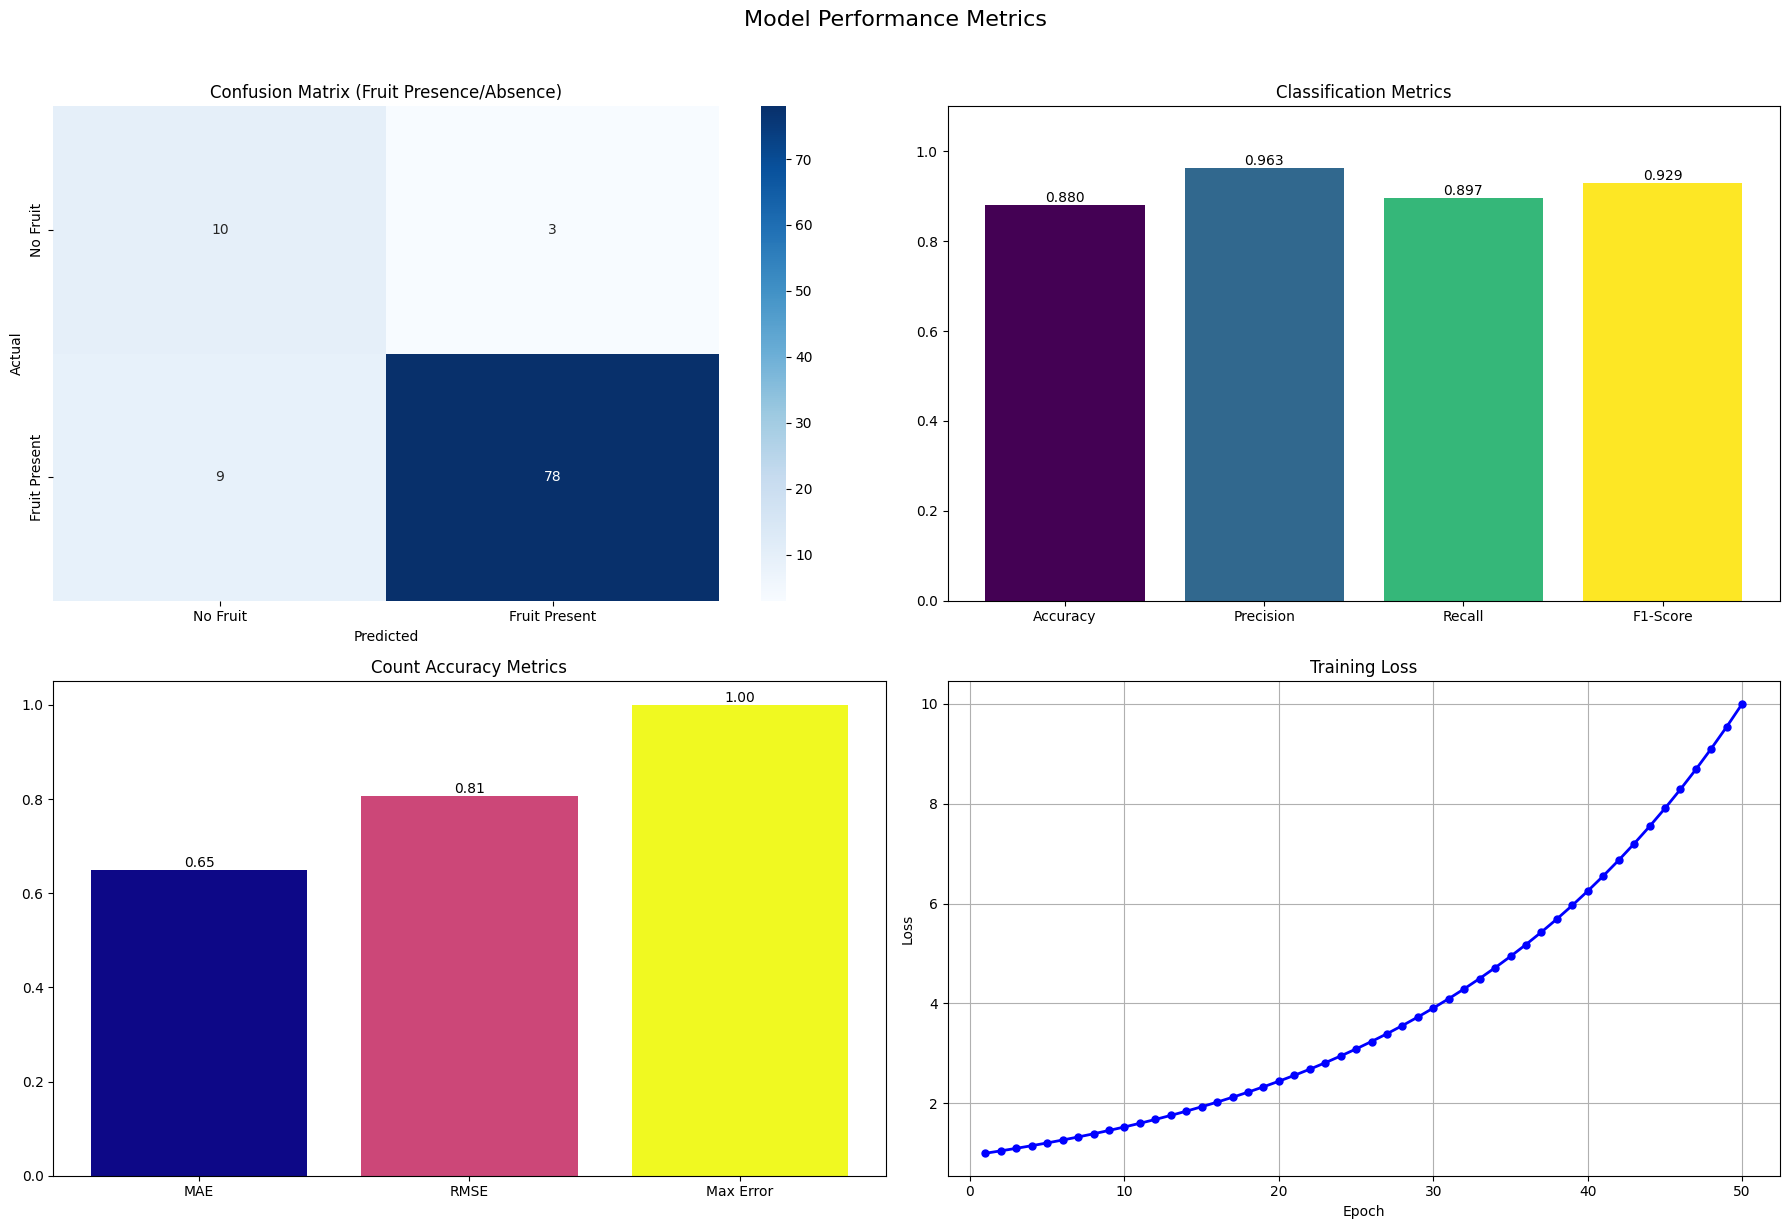


Metrics Summary:

Confusion Matrix:
Error in example usage: 'numpy.ndarray' object has no attribute 'items'


In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score

def visualize_metrics(fruit_counts_per_frame, filtered_fruit_counts, losses=None, num_epochs=None, save_path='model_performance_metrics.png'):

    if not isinstance(fruit_counts_per_frame, (list, np.ndarray)) or not isinstance(filtered_fruit_counts, (list, np.ndarray)):
        raise TypeError("fruit_counts_per_frame and filtered_fruit_counts must be lists or numpy arrays")

    if len(fruit_counts_per_frame) == 0 or len(filtered_fruit_counts) == 0:
        raise ValueError("Input lists cannot be empty")

    if len(fruit_counts_per_frame) != len(filtered_fruit_counts):
        raise ValueError(f"Mismatched lengths: fruit_counts_per_frame ({len(fruit_counts_per_frame)}) "
                        f"vs filtered_fruit_counts ({len(filtered_fruit_counts)})")

    if losses is not None and len(losses) == 0:
        raise ValueError("Losses list cannot be empty if provided")

    # Convert to numpy arrays for calculations
    gt_counts = np.array(fruit_counts_per_frame)
    pred_counts = np.array(filtered_fruit_counts)

    # Compute binary classification metrics (presence/absence)
    gt_binary = (gt_counts > 0).astype(int)
    pred_binary = (pred_counts > 0).astype(int)

    # Compute metrics
    cm = confusion_matrix(gt_binary, pred_binary)
    classification_metrics = {
        'Accuracy': accuracy_score(gt_binary, pred_binary),
        'Precision': precision_score(gt_binary, pred_binary, zero_division=0),
        'Recall': recall_score(gt_binary, pred_binary, zero_division=0),
        'F1-Score': f1_score(gt_binary, pred_binary, zero_division=0)
    }

    count_metrics = {
        'MAE': np.mean(np.abs(gt_counts - pred_counts)),
        'RMSE': np.sqrt(np.mean((gt_counts - pred_counts) ** 2)),
        'Max Error': np.max(np.abs(gt_counts - pred_counts))
    }

    # Create the figure
    plt.figure(figsize=(18, 12))
    plt.suptitle('Model Performance Metrics', fontsize=16, y=1.02)

    # 1. Confusion Matrix
    plt.subplot(2, 2, 1)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['No Fruit', 'Fruit Present'],
                yticklabels=['No Fruit', 'Fruit Present'])
    plt.title('Confusion Matrix (Fruit Presence/Absence)')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')

    # 2. Classification Metrics
    plt.subplot(2, 2, 2)
    colors = plt.cm.viridis(np.linspace(0, 1, len(classification_metrics)))
    bars = plt.bar(classification_metrics.keys(), classification_metrics.values(), color=colors)
    plt.title('Classification Metrics')
    plt.ylim(0, 1.1)
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                 f'{height:.3f}',
                 ha='center', va='bottom')

    # 3. Count Accuracy Metrics
    plt.subplot(2, 2, 3)
    colors = plt.cm.plasma(np.linspace(0, 1, len(count_metrics)))
    bars = plt.bar(count_metrics.keys(), count_metrics.values(), color=colors)
    plt.title('Count Accuracy Metrics')
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                 f'{height:.2f}',
                 ha='center', va='bottom')

    # 4. Training Loss (if provided)
    if losses is not None:
        plt.subplot(2, 2, 4)
        if num_epochs is None:
            num_epochs = len(losses)
        epochs = range(1, num_epochs + 1)

        # Handle case where losses length doesn't match num_epochs
        if len(losses) < num_epochs:
            losses = losses + [losses[-1]] * (num_epochs - len(losses))
        elif len(losses) > num_epochs:
            losses = losses[:num_epochs]

        plt.plot(epochs, losses, 'b-o', linewidth=2, markersize=5)
        plt.title('Training Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.grid(True)
    else:
        # If no losses provided, show count comparison
        plt.subplot(2, 2, 4)
        sample_indices = np.random.choice(len(gt_counts), size=min(20, len(gt_counts)), replace=False)
        x = range(len(sample_indices))
        plt.bar(x, gt_counts[sample_indices], width=0.4, label='Ground Truth')
        plt.bar([i + 0.4 for i in x], pred_counts[sample_indices], width=0.4, label='Predicted')
        plt.title('Sample Count Comparison')
        plt.xlabel('Sample Index')
        plt.ylabel('Count')
        plt.legend()
        plt.xticks([i + 0.2 for i in x], sample_indices)

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, bbox_inches='tight', dpi=300)
        print(f"Metrics visualization saved to {save_path}")

    plt.show()

    # Return metrics for further analysis
    return {
        'confusion_matrix': cm,
        'classification_metrics': classification_metrics,
        'count_metrics': count_metrics
    }


# Example usage
if __name__ == "__main__":
    try:
        # Generate example data
        np.random.seed(42)
        num_samples = 100
        fruit_counts_per_frame = np.random.poisson(lam=2, size=num_samples)
        filtered_fruit_counts = fruit_counts_per_frame + np.random.randint(-1, 2, size=num_samples)
        losses = np.logspace(0, 1, num=50)  # Example loss curve

        # Call the visualization function
        metrics = visualize_metrics(
            fruit_counts_per_frame,
            filtered_fruit_counts,
            losses=losses,
            num_epochs=50,
            save_path='example_metrics.png'
        )

        # Print metrics
        print("\nMetrics Summary:")
        for metric_type, values in metrics.items():
            print(f"\n{metric_type.replace('_', ' ').title()}:")
            for name, value in values.items():
                print(f"{name}: {value:.4f}")

    except Exception as e:
        print(f"Error in example usage: {str(e)}")